In [4]:
# This is just a function to allow toggleing code cells that are too long for good
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

# (A) Generate the Basic Extensive .h5 Grid for $w_0,R_0,Z$
## The intermediate D matrix is saved such that any $\phi_{CR}$ may be generated from it
### Useful for the Simulation fitting algorithms for example

In [1]:
import os
os.chdir(f"../../..")
from SOURCE.CLASS_CODE_GPU_Classes import *
from SOURCE.CLASS_CODE_Image_Manager import *
import numpy as np
import json
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
from time import time
import h5py

In [2]:
# Set the PARAMETERS ############################################
##################################################################
experiment_name="Basler_like_R0_300x_w0_300x_Z_50x_64bit"
N_R0 = 70 #130
N_w0 = 70 #130
N_Z = 4 #8

output_directory=f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/{experiment_name}/"
#output_directory=f"./OUTPUT/LIBRARIES_OF_THEORETICAL_D/{experiment_name}/"
#os.chdir(f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/")

randomization_seed=666
image_shortest_side=540
saturation=1

# Ring parameters to test (each will be a different simulation)
#phiCR_s=np.linspace(-180,180,360*10**significant_decimal+1)*np.pi/180
R0_s=np.linspace(70, 180, N_R0) #np.linspace(70,180,40) # in pxels 153
w0_s=np.linspace( 8, 40, N_w0) #np.linspace(8,50,40) 11
Z_s=np.linspace(0, 0.9, N_Z)
rho_0s=R0_s/w0_s


resolution_side_nx=image_shortest_side # generated images will be resolution_side x resolution_side
# Other parameters
max_k=50
num_k=1200
sim_chunk_ax=image_shortest_side



##################################################
##################################################

# General considerations
image_directory=f"{output_directory}/SIMULATIONS/" #nx_{image_shortest_side}_depth_{image_depth}_sat_{saturation}
os.makedirs(image_directory, exist_ok=True)
np.random.seed(randomization_seed)

In order to do this data generation in parallel, we will generate the data in parallel processes.
Eventually, when all is finished, we will manually generate a single h5f from the individual parts.

In [47]:
K=5 # workers
N=56 # tareas

for j in range(K):
    print(f"Worker {j} -> {(N//K)*j + j*((N%K-j)>0) + (N%K)*(j>=N%K) } to {(N//K)*(j+1) + (j+1)*((N%K-j-1)>0)+ (N%K)*(j+1>=N%K)}")

Worker 0 -> 0 to 12
Worker 1 -> 12 to 23
Worker 2 -> 23 to 34
Worker 3 -> 34 to 45
Worker 4 -> 45 to 56


In [3]:
TOTAL_WORKERS = 2
WORKER_ID = 0 # beginning from 0 till TOTAL_WORKERS-1

def beg_index(N,j,K):
    # N -> number of total elements in vector, j is worker id, K is total number of workers
    return (N//K)*j + j*((N%K-j)>0) + (N%K)*(j>=N%K)
def end_index(N,j,K):
    return (N//K)*(j+1) + (j+1)*((N%K-j-1)>0)+ (N%K)*(j+1>=N%K)

# we just need to partitionate one of the vectors! If you do it with all of them you do not get the whole!!!
R0_s = R0_s[beg_index(N_R0, WORKER_ID, TOTAL_WORKERS):end_index(N_R0, WORKER_ID, TOTAL_WORKERS)] 
# w0_s = w0_s[beg_index(N_w0, WORKER_ID, TOTAL_WORKERS):end_index(N_w0, WORKER_ID, TOTAL_WORKERS)] 
# Z_s = Z_s[beg_index(N_Z, WORKER_ID, TOTAL_WORKERS):end_index(N_Z, WORKER_ID, TOTAL_WORKERS)]
# rho_0s=R0_s/w0_s

### Using h5f

In [4]:
# Initialize the vigilant
try:
    phase_vigilant = json.load(open(f"{output_directory}/STRUCTURE_Grid_PART_{WORKER_ID}.json"))
except:
    phase_vigilant = {'R0s':[], 'w0s':[], 'Zs':[], 'IDs':[]}

# Set the objects ready ##################
# The simulator object
simulator =RingSimulator_Optimizer_GPU( n=1.5, a0=1.0, max_k=max_k, num_k=num_k, nx=resolution_side_nx, 
                                      sim_chunk_x=sim_chunk_ax, sim_chunk_y=sim_chunk_ax)

# Initialize the hdf5 dataset saver
h5f = h5py.File(f"{image_directory}/Dataset_PART_{WORKER_ID}.h5", 'a') # append if exists, create if not

# save phis
try:
    h5f.create_dataset('phis', data=simulator.phis[:,:,0], compression="lzf", shuffle=True) #, compression_opts=9)
except:
    print(f"phis was already in h5f but not in phase vigilant")
    h5f['phis'][:] = simulator.phis[:,:,0]

# Execute the stuff #####################
i=1
total=Z_s.shape[0]*R0_s.shape[0]*w0_s.shape[0]
elapsed=0
beg=time()
output_info_every=25
dump_every=25

for Z in Z_s:
    for R0 in R0_s:
        for w0 in w0_s:
            ID=f"R0_{str(R0)}_w0_{str(w0)}_Z_{str(Z)}"
            if ID not in phase_vigilant['IDs']:
                # simulate matrix
                D_matrix = simulator.compute_pieces_for_I_LP(R0_pixels=R0, Z=Z, w0_pixels=w0)
                
                if D_matrix is None:
                    raise ValueError
                    
                # save the matrix
                try:
                    h5f.create_dataset(ID, data=D_matrix, compression="lzf", shuffle=True) #, compression_opts=9)
                except: # in case the phase_vigilant did not record it, but it was already in h5f
                    print(f"{ID} was already in h5f but not in phase vigilant")
                    h5f[ID][:] = D_matrix

                #append the data
                phase_vigilant['IDs'].append(ID)
                phase_vigilant['R0s'].append(str(R0))
                phase_vigilant['Zs'].append(str(Z))
                phase_vigilant['w0s'].append(str(w0))
                
                
                if i%output_info_every==0:
                    display.clear_output(wait=True)
                    elapsed=time()-beg
                    print(f"["+'#'*(int(100*i/total))+' '*(100-int(100*i/total))+f"] {100*i/total:3.4}% \n\nSimulated: {i}/{total}\nElapsed time: {elapsed//3600} h {elapsed//60-(elapsed//3600)*60} min {elapsed-(elapsed//60)*60-(elapsed//3600)*60:2.4} s")
                    if i%dump_every==0:
                        h5f.flush()
                        # we save the progess (in order to be able to quit and resume)
                        json.dump(phase_vigilant, open( f"{output_directory}/STRUCTURE_Grid_PART_{WORKER_ID}.json", "w"))
            i+=1
            
display.clear_output(wait=True)
elapsed=time()-beg
print(f"["+'#'*(int(100*i/total))+' '*(100-int(100*i/total))+f"] {100*i/total:3.4}% \n\nSimulated: {i}/{total}\nElapsed time: {elapsed//3600} h {elapsed//60-(elapsed//3600)*60} min {elapsed-(elapsed//60)*60-(elapsed//3600)*60:2.4} s")               
h5f.flush()
# we save the progess (in order to be able to quit and resume)
json.dump(phase_vigilant, open( f"{output_directory}/STRUCTURE_Grid_PART_{WORKER_ID}.json", "w"))

h5f.close()
print(f"\n\nWORKER {WORKER_ID} FINISHED!!!")

[####################################################################################################] 100.0% 

Simulated: 9801/9800
Elapsed time: 10.0 h 44.0 min -547.4 s


WORKER 0 FINISHED!!!


In [5]:
h5f.flush()
h5f.close()

Now the code to join all the parts individually generated!

In [4]:
#raise ValueError
# Open the big h5f that will contain all of the parts
h5f = h5py.File(f"{image_directory}/Dataset_R0_{N_R0}_w0_{N_w0}_Z_{N_Z}.h5", 'w') # append if exists, create if not
total_phase = {'R0s':[], 'w0s':[], 'Zs':[], 'IDs':[]}
for j in range(TOTAL_WORKERS):
    h5f_worker = h5py.File(f"{image_directory}/Dataset_PART_{j}.h5", 'r')
    phase_worker = json.load(open(f"{output_directory}/STRUCTURE_Grid_PART_{j}.json"))
    if j==0:
        h5f.create_dataset('phis', data=h5f_worker['phis'][:], compression="lzf", shuffle=True)
    for ID in phase_worker['IDs']:
        h5f.create_dataset(ID, data=h5f_worker[ID][:], compression="lzf", shuffle=True)
    total_phase['R0s'] = total_phase['R0s'] + phase_worker['R0s']
    total_phase['w0s'] = total_phase['w0s'] + phase_worker['w0s']
    total_phase['Zs'] = total_phase['Zs'] + phase_worker['Zs']
    total_phase['IDs'] = total_phase['IDs'] + phase_worker['IDs']
    h5f_worker.close()
    print(f"Worker {j} done!")
json.dump(total_phase, open( f"{output_directory}/STRUCTURE_Grid_R0_{N_R0}_w0_{N_w0}_Z_{N_Z}.json", "w"))
h5f.close()

Worker 0 done!
Worker 1 done!


# (B) Using h5 from (A) Generate a Random NOISY Image Library (with just the ground-truth angle $\phi_{CR}$)
## Images in .png format and labels in their names
### Useful for the CNN-s and Emedders just dealing with the Noisy images and the GT $\phi_{CR}$

First, here (in the hidden cell) is the Dataset and Sampler classes designed to use the $.h5$ from (A) directly. It will be used to retrieve the pure images to which afterwards a random noising is applied. These will then be written to $.png$ images

In [2]:
hide_toggle(for_next=True)

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, Sampler, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
#device="cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

'''
La idea es que cada 5 epochs, se cambie el dataset efectivo, que sera un subset de los R0,w0,Z posibles
multiplicado por el batch size (phiCR posibles). En cada batch, las imagenes enviadas seran todas
de un mismo D matrix (R0,w0,Z) con diferentes angulos elegidos aleatoriamente con una uniforme
'''
class R0_w0_Z_Sampler(Sampler):
    def __init__(self, R0_weights, w0_weights, Z_weights, num_batches_per_epoch):
        self.num_batches = num_batches_per_epoch
        self.R0_weights = R0_weights
        self.w0_weights = w0_weights
        self.Z_weights = Z_weights

    def __iter__(self):
        return iter(torch.stack((
            torch.multinomial(self.R0_weights, self.num_batches, replacement=True),
            torch.multinomial(self.w0_weights, self.num_batches, replacement=True),
            torch.multinomial(self.Z_weights, self.num_batches, replacement=True)),
            dim=1).tolist())

    def __len__(self):
        return self.num_samples


class CR_Dataset(Dataset):
    def __init__(self, D_matrix_file_path, ID_file_path, device, X=605, generate_images_w_depth=8, random_seed=666, 
                batch_size=10, num_batches_per_epoch=100, apply_noise=True,
                all_stregths_random_per_epoch=False,
                max_poisson_strength=0.5, max_blob_strength=0.5, max_angular_modulation_strength=0.5,
                poisson_strength=0.3, blob_strength=0.1, angular_modulation_strength=0.25,
                min_modulation_frec=2*np.pi/6, max_modulation_frec=2*np.pi/2,
                max_blobs=1, min_blob_sigma=100, max_blob_sigma=130
                ):
        # If all_strengths_random_per_ecpoh, then arguments about the maximum will be valid while not the strength arguments
        # If false, then the arguments about the particular stregths will be the global stregths
        np.random.seed(random_seed) 
        torch.manual_seed(random_seed)
        self.D_matrix_file_path=D_matrix_file_path
        self.df_GTs = pd.DataFrame.from_dict(json.load(open(ID_file_path)))       
        self.R0s = list(self.df_GTs['R0s'].drop_duplicates()) # Note they are lists of strings!
        self.w0s = list(self.df_GTs['w0s'].drop_duplicates())
        self.Zs = list(self.df_GTs['Zs'].drop_duplicates())
        self.batch_size = batch_size
        self.num_batches_per_epoch = num_batches_per_epoch
        self.epoch_size = batch_size*num_batches_per_epoch
        self.device = device
        self.im_type = torch.uint16 if generate_images_w_depth==16 else torch.uint8
        self.max_intensity = 65535 if generate_images_w_depth==16 else 254
        self.X=X
        self.apply_noise=apply_noise
        self.poisson_strength=poisson_strength
        self.blob_strength=blob_strength
        self.angular_modulation_strength=angular_modulation_strength
        self.min_modulation_frec=min_modulation_frec
        self.max_modulation_frec=max_modulation_frec
        self.max_blobs=max_blobs
        self.min_blob_sigma=min_blob_sigma
        self.max_blob_sigma=max_blob_sigma
        self.all_stregths_random_per_epoch=all_stregths_random_per_epoch
        self.max_poisson_strength=max_poisson_strength
        self.max_blob_strength=max_blob_strength
        self.max_angular_modulation_strength=max_angular_modulation_strength
        
    #def update_dataset o set_epoch_number y que aqui se genere directamente el dataset entero para las epochs que vienen
    # lo que permitiria es que cada X epochs, se ahorrase el tener que re-generar todas las imagenes
    # Pero claro, la pregunta es, la RAM aguantaria?
    # Si haces con update_dataset, entonces no haria falta hacer un sampler custom, con el normal ya bastaria
    
    # Bueno, por ahora, vamos a hacer que en cada minibatch, se haga todo el puroceso. La cosa es que asi se 
    # puede aprovechar el multiprocessing innato, si no habria que hacer el multiprocessing dentroe del update_dataset
    # o simplemente prescindir de hacerlo supongo.
    
    def __del__(self):
        if hasattr(self, 'h5f_D_matrices'):
            self.h5f_D_matrices.close()
        
    def __len__(self):
        return self.epoch_size
    
    def open_hdf5(self):
        self.h5f_D_matrices = h5py.File( self.D_matrix_file_path, 'r')
        #self.dataset = self.img_hdf5['dataset'] # if you want dataset.
        

    def compute_intensity_gravity_centers(self, images):
        """
            Expects input image to be an array of dimensions [N_imgs, h, w].
            It will return an array of gravity centers [N_imgs, 2(h,w)] in pixel coordinates
            Remember that pixel coordinates are set equal to array indices

        """
        # image wise total intensity and marginalized inensities for weighted sum
        intensity_in_w = torch.sum(images, dim=1) # weights for x [N_images, raw_width]
        intensity_in_h = torch.sum(images, dim=2) # weights for y [N_images, raw_height]
        total_intensity = intensity_in_h.sum(dim=1) # [N_images]

        # Compute mass center for intensity
        # [N_images, 2] (h_center,w_center)
        return torch.nan_to_num( torch.stack(
            (torch.matmul(intensity_in_h.float(), torch.arange(images.shape[1], 
                                        dtype=torch.float32, device=self.device))/total_intensity,
             torch.matmul(intensity_in_w.float(), torch.arange(images.shape[2], 
                                        dtype=torch.float32, device=self.device))/total_intensity),
            dim=1
            ), nan=0.0, posinf=None, neginf=None)

    def compute_raw_to_centered_iX(self, images):

        g_raw = self.compute_intensity_gravity_centers(images) # [ N_images, 2]

        # crop the iamges with size (X+1+X)^2 leaving the gravity center in
        # the central pixel of the image. In case the image is not big enough for the cropping,
        # a 0 padding will be made.
        centered_images = torch.zeros( ( images.shape[0], 2*self.X+1, 2*self.X+1),  dtype = images.dtype, 
                                      device=self.device)

        # we round the gravity centers to the nearest pixel indices
        g_index_raw = torch.round(g_raw).int() #[ N_images, 2]

        # obtain the slicing indices around the center of gravity
        # TODO -> make all this with a single array operation by stacking the lower and upper in
        # a new axis!!
        # [ N_images, 2 (h,w)]
        unclipped_lower = g_index_raw-self.X
        unclipped_upper = g_index_raw+self.X+1

        # unclipped could get out of bounds for the indices, so we clip them
        lower_bound = torch.clip( unclipped_lower.float(), min=torch.Tensor([[0,0]]).to(self.device),
                                 max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(self.device)).int()
        upper_bound = torch.clip( unclipped_upper.float(), min=torch.Tensor([[0,0]]).to(self.device),
                                 max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(self.device)).int()
        # we use the difference between the clipped and unclipped to get the necessary padding
        # such that the center of gravity is left still in the center of the image
        padding_lower = lower_bound-unclipped_lower
        padding_upper = upper_bound-unclipped_upper

        # crop the image
        for im in range(g_raw.shape[0]):
            centered_images[im, padding_lower[ im, 0]:padding_upper[ im, 0] or None,
                                        padding_lower[ im, 1]:padding_upper[ im, 1] or None] = \
                      images[im, lower_bound[ im, 0]:upper_bound[ im, 0],
                                          lower_bound[ im, 1]:upper_bound[ im, 1]]

        return centered_images
    
    def apply_random_camera_noises(self, images):
        # Poisson noise
        # the images are expected to already be normalized and in the integer range of the camera
        return torch.clamp((1-self.poisson_strength)*images+self.poisson_strength*torch.poisson(images), max=self.max_intensity) 
                                    # rates are the expected intensities of the imaging time

    def _gaussian_2D_pdfs(self, x_ys, mus, sigmas, strengths):
        '''
        x_ys : [batch_size, blob_num, 2 (h,w), 2X+1, 2X+1]
        mus : [batch_size, blob_num, 2 (h,w), 1, 1]
        sigmas : [batch_size, blob_num, 2(h,w), 1, 1]
        strengths : [batch_size, blob_num, 1, 1]
        ------
        out : [batch_size, 2X+1, 2X+1]
        '''
        gaussians = torch.sum((strengths/(2*np.pi)/sigmas[:,:,0]/sigmas[:,:,1])*torch.exp(
                -(x_ys[:,:,0,:,:]-mus[:,:,0])**2/(2*sigmas[:,:,0]**2))*torch.exp(
                -(x_ys[:,:,1,:,:]-mus[:,:,1])**2/(2*sigmas[:,:,1]**2)), dim=1) # since strength is normalized, the whole mixture is normalized as well
        return gaussians/gaussians.amax(dim=(1,2)).unsqueeze(1).unsqueeze(2)

    def apply_random_pre_camera_noises(self, images):
        # note that the input images are expected to still be centered in the gravicenter and have no normalization

        # Gaussian Blobs - subtract gaussian blobs of different depths to the intensity pattern
        # First randomly sample the centers of the blobs and their standard deviations for each image
        # we will sample the means with probabilities proportional to the CR ring intensity pattern
        blob_num = np.random.randint(0, self.max_blobs+1, size=1)[0]
        if blob_num!=0:
            mu_s = torch.stack(
                (torch.multinomial(images.sum(dim=2),
                        num_samples=blob_num, 
                        replacement=False), 
                 torch.multinomial(images.sum(dim=1),
                        num_samples=blob_num, 
                        replacement=False) ),
                 dim=2
                ).to(self.device) #[batch_size, blob_num, 2(h,w)] mu-s are in pixel units and coordinates

            sigma_s = torch.from_numpy(np.random.randint(self.min_blob_sigma, self.max_blob_sigma, 
                        size=(images.shape[0], blob_num, 2))).to(self.device) #[batch_size, blob_num, 2(h,w)]
            strengths = torch.rand(size=(images.shape[0], blob_num)).to(self.device) #[batch_size, blob_num]
            strengths = strengths/strengths.sum(dim=1).unsqueeze(1) # normalized strengths between blobs

            w = torch.arange(images.shape[1]).repeat((images.shape[1],1)).to(self.device)
            h = w.transpose(0,1).to(self.device)
            h_w = torch.stack((h,w), dim=0).to(self.device)
            images = images*(1-self.blob_strength*self._gaussian_2D_pdfs( h_w.view((1,1)+h_w.shape), 
                mu_s.view(mu_s.shape+(1,1)), sigma_s.view(sigma_s.shape+(1,1)), strengths.view(strengths.shape+(1,1)) )
                     )           #[batch_size, 2X+1, 2X+1]        
        # Poisson noise - makes the intesity be a poissonian generated value instead of the expected values
        #images = (1-poisson_strength)*images+poisson_strength*torch.poisson(images) # rates are the expected intensities of the imaging time
        # but must be an integer matrix!

        # Angular Modulation - apply a pseudo-random continous wave modulation to the ring angularly
        random_frecs = (self.min_modulation_frec + (self.max_modulation_frec-self.min_modulation_frec)*torch.rand(
                                size=(3,images.shape[0], 1,1))).to(self.device)
        strengths = torch.rand(size=(3, images.shape[0], 1,1)).to(self.device) #[3, batch_size, 1,1]
        strengths = strengths/strengths.sum(dim=0) # normalized strengths between sin and coss
        images = images*(
            1-self.angular_modulation_strength*(
                strengths[0]*torch.cos(random_frecs[0]*self.phis)+
                strengths[1]*torch.sin(random_frecs[1]*self.phis)+
                strengths[2]*torch.cos(random_frecs[2]*self.phis)
            )**2) #[batch_size, 2X+1, 2X+1]

        # Angular-Radial Modulation # sería coger phis y coger radios y con eso hacer uan funcion de ambas, de forma
        # que por ejemplo afecte de manera diferente al mismo angulo en cada ring el pre-pogendorf y el otro

        # Modos superiores
        # esto ya es un jaleo xD
        return images

    
    
    def __getitem__(self, R0_w0_Z_idxs):
        # In order to allow multiprocessing data loading, each worker needs to initialize 
        # the h5f loader, which must be done in the first iteration of getitem and not in the init
        # of the parent process
        if not hasattr(self, 'h5f_D_matrices'):
            self.open_hdf5()
            self.phis = torch.from_numpy(self.h5f_D_matrices['phis'][:]).unsqueeze(0).to(self.device) #[1,Nx,Ny]

        D_mats = torch.from_numpy(self.h5f_D_matrices[
                f"R0_{self.R0s[R0_w0_Z_idxs[0]]}_w0_{self.w0s[R0_w0_Z_idxs[1]]}_Z_{self.Zs[R0_w0_Z_idxs[2]]}"][:]
                                 ).unsqueeze(1).to(self.device) #[2, 1, Nx, Ny]            
         
        phiCRs = torch.FloatTensor(self.batch_size, 1, 1).uniform_(-np.pi, np.pi).to(self.device) #[batch_size, 1, 1]
        images = D_mats[0]+D_mats[1]*torch.cos(phiCRs-self.phis) #[batch_size, Nx,Ny]
        
        if self.apply_noise:
            if self.all_stregths_random_per_epoch:
                self.poisson_strength = self.max_poisson_strength*np.random.rand()
                self.angular_modulation_strength = self.max_angular_modulation_strength*np.random.rand()
                self.blob_strength = self.max_blob_strength*np.random.rand()
            
            # Apply precamera noise to images (while still floats)
            images = self.apply_random_pre_camera_noises(images)
        
        # convert images to selected uint format
        images = (self.max_intensity*(images/images.amax(dim=(1,2), keepdim=True)[0].unsqueeze(1)))
        
        if self.apply_noise:
            # Apply camera noises (now that normalized and integers)
            images = self.apply_random_camera_noises(images)
        
        images = images.type(self.im_type)

        # get iX images
        images = self.compute_raw_to_centered_iX(images) #[batch_size, 2X+1, 2X+1]
        labels = torch.Tensor([[float(self.R0s[R0_w0_Z_idxs[0]]), float(self.w0s[R0_w0_Z_idxs[1]]), 
                               float(self.Zs[R0_w0_Z_idxs[2]])]]).to(self.device) #[1,4]
        labels = torch.hstack( ( labels.expand(self.batch_size, 3), phiCRs.squeeze(2) ) ) #[4, batch_size]
        del D_mats, phiCRs
        torch.cuda.empty_cache()
        return images, labels #[ batch_size, 2X+1, 2X+1] and [batch_size, 4]
        # The whole batch is already in the GPU, since to process it we wanted it to be there
    

cuda:0


In [2]:
import os
import cv2
import json
import h5py
from IPython import display

output_directory="/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/IMAGE_LIBRARY/NOISY/TRAIN/"
#output_directory="/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/IMAGE_LIBRARY/NON_NOISY/TRAIN/"

os.makedirs(output_directory, exist_ok=True)

In [3]:
ID_file_path= "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/STRUCTURE_Grid_R0_70_w0_70_Z_4.json"
D_matrix_file_path= "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Encoder_Alone/Dataset_R0_70_w0_70_Z_4.h5"
        

total_images_to_generate = 500000 # para el test set unos 100000 bien supongo

batch_size = 10
number_of_batches_per_epoch = int(total_images_to_generate/batch_size)

assert(total_images_to_generate%batch_size==0)

X=302
generate_images_w_depth=8
random_seed=666 # 669 aldatu seede para generar los validation set!!!

apply_noise=True # Genera otro dataset pair sin noise tb
all_stregths_random_per_epoch=True
max_poisson_strength=0.5
max_blob_strength=0.5
max_angular_modulation_strength=0.5
poisson_strength=0.4
blob_strength=0.2
angular_modulation_strength=0.2
min_modulation_frec=2*np.pi/6
max_modulation_frec=2*np.pi/2
max_blobs=2
min_blob_sigma=100
max_blob_sigma=130

In [4]:
def gaussian_pdf(x, mu, sigma, normalized_output=True):
    p_s = (1/np.sqrt(2*np.pi)/sigma)*torch.exp(-(x-mu)**2/(2*sigma**2))
    return p_s/p_s.sum() if normalized_output else p_s

phase_vigilant = pd.DataFrame.from_dict(json.load(open(ID_file_path)))
R0_weights = gaussian_pdf(torch.from_numpy(np.array( phase_vigilant['R0s'].drop_duplicates(), dtype=np.float64)),
                          mu=158, sigma=8)
w0_weights = gaussian_pdf(torch.from_numpy(np.array( phase_vigilant['w0s'].drop_duplicates(), dtype=np.float64)),
                          mu=25, sigma=4)
Z_weights = gaussian_pdf(torch.from_numpy(np.array( phase_vigilant['Zs'].drop_duplicates(), dtype=np.float64)),
                          mu=0, sigma=0.3)

In [5]:
sampler = R0_w0_Z_Sampler( R0_weights, w0_weights, Z_weights, num_batches_per_epoch=number_of_batches_per_epoch)
dataset = CR_Dataset(D_matrix_file_path=D_matrix_file_path,
            ID_file_path =ID_file_path, 
            device = device,
            X=X, generate_images_w_depth=generate_images_w_depth, random_seed=random_seed, 
            batch_size=batch_size, num_batches_per_epoch=number_of_batches_per_epoch,
            apply_noise=apply_noise, all_stregths_random_per_epoch=all_stregths_random_per_epoch,
            max_poisson_strength=max_poisson_strength, max_blob_strength=max_blob_strength,
            max_angular_modulation_strength=max_angular_modulation_strength,
            poisson_strength=poisson_strength, blob_strength=blob_strength, 
            angular_modulation_strength=angular_modulation_strength,
            min_modulation_frec=min_modulation_frec, max_modulation_frec=max_modulation_frec,
            max_blobs=max_blobs, min_blob_sigma=min_blob_sigma, max_blob_sigma=max_blob_sigma)

In [6]:
%%time
j=0
output_info_every=100
ground_truths={'ID':[], 'phiCR':[]}
for i in sampler:
    imgs, labs = dataset[i]
    imgs = np.asarray(imgs.to('cpu'))
    labs = np.asarray(labs.to('cpu'))
    for k in range(imgs.shape[0]):
        cv2.imwrite(f"{output_directory}/IM_{j}_phiCR_{labs[k][-1]}.png", imgs[k])
        ground_truths['ID'].append(j)
        ground_truths['phiCR'].append(f"{labs[k][-1]}")
        j+=1
        if j%output_info_every==0:
            display.clear_output(wait=True)
            print(f"Processed {j}/{total_images_to_generate} images {j/total_images_to_generate*100} %")
json.dump(ground_truths, open( f"{output_directory}/GROUND_TRUTHS.json", "w"))

Processed 500000/500000 images 100.0 %
CPU times: user 3h 41min 3s, sys: 5min 24s, total: 3h 46min 27s
Wall time: 55min 50s


# (C) Using h5 (A) Generate a Random NOISY and corresponding NON-NOISY Image h5 Dataset
# (with the GT denoised image and the ground-truth angle $\phi_{CR}$)
## Noisy and Original Images in numpy array batches in an h5 format and labels in a json relating the index of the h5 with the ground-truth $phi_CR$ list
### Useful for the Denoising CNN-s and Metric Generator

First, here (in the hidden cell) is the Dataset and Sampler classes designed to use the $.h5$ from (A) directly. It will be used to retrieve the pure images to which afterwards a random noising is applied. It will have a little modification to allow the retrieval of the denoised images as well. These will be packed in batches of uint8 images to write them to an $.h5$ file.

In [5]:
hide_toggle(for_next=True)

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, Sampler, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
#device="cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

'''
La idea es que cada 5 epochs, se cambie el dataset efectivo, que sera un subset de los R0,w0,Z posibles
multiplicado por el batch size (phiCR posibles). En cada batch, las imagenes enviadas seran todas
de un mismo D matrix (R0,w0,Z) con diferentes angulos elegidos aleatoriamente con una uniforme
'''
class R0_w0_Z_Sampler(Sampler):
    def __init__(self, R0_weights, w0_weights, Z_weights, num_batches_per_epoch):
        self.num_batches = num_batches_per_epoch
        self.R0_weights = R0_weights
        self.w0_weights = w0_weights
        self.Z_weights = Z_weights

    def __iter__(self):
        return iter(torch.stack((
            torch.multinomial(self.R0_weights, self.num_batches, replacement=True),
            torch.multinomial(self.w0_weights, self.num_batches, replacement=True),
            torch.multinomial(self.Z_weights, self.num_batches, replacement=True)),
            dim=1).tolist())

    def __len__(self):
        return self.num_samples


class CR_Dataset(Dataset):
    def __init__(self, D_matrix_file_path, ID_file_path, device, X=605, generate_images_w_depth=8, random_seed=666, 
                batch_size=10, num_batches_per_epoch=100, apply_noise=True,
                all_stregths_random_per_epoch=False,
                max_poisson_strength=0.5, max_blob_strength=0.5, max_angular_modulation_strength=0.5,
                poisson_strength=0.3, blob_strength=0.1, angular_modulation_strength=0.25,
                min_modulation_frec=2*np.pi/6, max_modulation_frec=2*np.pi/2,
                max_blobs=1, min_blob_sigma=100, max_blob_sigma=130
                ):
        # If all_strengths_random_per_ecpoh, then arguments about the maximum will be valid while not the strength arguments
        # If false, then the arguments about the particular stregths will be the global stregths
        np.random.seed(random_seed) 
        torch.manual_seed(random_seed)
        self.D_matrix_file_path=D_matrix_file_path
        self.df_GTs = pd.DataFrame.from_dict(json.load(open(ID_file_path)))       
        self.R0s = list(self.df_GTs['R0s'].drop_duplicates()) # Note they are lists of strings!
        self.w0s = list(self.df_GTs['w0s'].drop_duplicates())
        self.Zs = list(self.df_GTs['Zs'].drop_duplicates())
        self.batch_size = batch_size
        self.num_batches_per_epoch = num_batches_per_epoch
        self.epoch_size = batch_size*num_batches_per_epoch
        self.device = device
        self.im_type = torch.uint16 if generate_images_w_depth==16 else torch.uint8
        self.max_intensity = 65535 if generate_images_w_depth==16 else 254
        self.X=X
        self.apply_noise=apply_noise
        self.poisson_strength=poisson_strength
        self.blob_strength=blob_strength
        self.angular_modulation_strength=angular_modulation_strength
        self.min_modulation_frec=min_modulation_frec
        self.max_modulation_frec=max_modulation_frec
        self.max_blobs=max_blobs
        self.min_blob_sigma=min_blob_sigma
        self.max_blob_sigma=max_blob_sigma
        self.all_stregths_random_per_epoch=all_stregths_random_per_epoch
        self.max_poisson_strength=max_poisson_strength
        self.max_blob_strength=max_blob_strength
        self.max_angular_modulation_strength=max_angular_modulation_strength
        
    #def update_dataset o set_epoch_number y que aqui se genere directamente el dataset entero para las epochs que vienen
    # lo que permitiria es que cada X epochs, se ahorrase el tener que re-generar todas las imagenes
    # Pero claro, la pregunta es, la RAM aguantaria?
    # Si haces con update_dataset, entonces no haria falta hacer un sampler custom, con el normal ya bastaria
    
    # Bueno, por ahora, vamos a hacer que en cada minibatch, se haga todo el puroceso. La cosa es que asi se 
    # puede aprovechar el multiprocessing innato, si no habria que hacer el multiprocessing dentroe del update_dataset
    # o simplemente prescindir de hacerlo supongo.
    
    def __del__(self):
        if hasattr(self, 'h5f_D_matrices'):
            self.h5f_D_matrices.close()
        
    def __len__(self):
        return self.epoch_size
    
    def open_hdf5(self):
        self.h5f_D_matrices = h5py.File( self.D_matrix_file_path, 'r')
        #self.dataset = self.img_hdf5['dataset'] # if you want dataset.
        

    def compute_intensity_gravity_centers(self, images):
        """
            Expects input image to be an array of dimensions [N_imgs, h, w].
            It will return an array of gravity centers [N_imgs, 2(h,w)] in pixel coordinates
            Remember that pixel coordinates are set equal to array indices

        """
        # image wise total intensity and marginalized inensities for weighted sum
        intensity_in_w = torch.sum(images, dim=1) # weights for x [N_images, raw_width]
        intensity_in_h = torch.sum(images, dim=2) # weights for y [N_images, raw_height]
        total_intensity = intensity_in_h.sum(dim=1) # [N_images]

        # Compute mass center for intensity
        # [N_images, 2] (h_center,w_center)
        return torch.nan_to_num( torch.stack(
            (torch.matmul(intensity_in_h.float(), torch.arange(images.shape[1], 
                                        dtype=torch.float32, device=self.device))/total_intensity,
             torch.matmul(intensity_in_w.float(), torch.arange(images.shape[2], 
                                        dtype=torch.float32, device=self.device))/total_intensity),
            dim=1
            ), nan=0.0, posinf=None, neginf=None)

    def compute_raw_to_centered_iX(self, images):

        g_raw = self.compute_intensity_gravity_centers(images) # [ N_images, 2]

        # crop the iamges with size (X+1+X)^2 leaving the gravity center in
        # the central pixel of the image. In case the image is not big enough for the cropping,
        # a 0 padding will be made.
        centered_images = torch.zeros( ( images.shape[0], 2*self.X+1, 2*self.X+1),  dtype = images.dtype, 
                                      device=self.device)

        # we round the gravity centers to the nearest pixel indices
        g_index_raw = torch.round(g_raw).int() #[ N_images, 2]

        # obtain the slicing indices around the center of gravity
        # TODO -> make all this with a single array operation by stacking the lower and upper in
        # a new axis!!
        # [ N_images, 2 (h,w)]
        unclipped_lower = g_index_raw-self.X
        unclipped_upper = g_index_raw+self.X+1

        # unclipped could get out of bounds for the indices, so we clip them
        lower_bound = torch.clip( unclipped_lower.float(), min=torch.Tensor([[0,0]]).to(self.device),
                                 max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(self.device)).int()
        upper_bound = torch.clip( unclipped_upper.float(), min=torch.Tensor([[0,0]]).to(self.device),
                                 max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(self.device)).int()
        # we use the difference between the clipped and unclipped to get the necessary padding
        # such that the center of gravity is left still in the center of the image
        padding_lower = lower_bound-unclipped_lower
        padding_upper = upper_bound-unclipped_upper

        # crop the image
        for im in range(g_raw.shape[0]):
            centered_images[im, padding_lower[ im, 0]:padding_upper[ im, 0] or None,
                                        padding_lower[ im, 1]:padding_upper[ im, 1] or None] = \
                      images[im, lower_bound[ im, 0]:upper_bound[ im, 0],
                                          lower_bound[ im, 1]:upper_bound[ im, 1]]

        return centered_images
    
    def apply_random_camera_noises(self, images):
        # Poisson noise
        # the images are expected to already be normalized and in the integer range of the camera
        return torch.clamp((1-self.poisson_strength)*images+self.poisson_strength*torch.poisson(images), max=self.max_intensity) 
                                    # rates are the expected intensities of the imaging time

    def _gaussian_2D_pdfs(self, x_ys, mus, sigmas, strengths):
        '''
        x_ys : [batch_size, blob_num, 2 (h,w), 2X+1, 2X+1]
        mus : [batch_size, blob_num, 2 (h,w), 1, 1]
        sigmas : [batch_size, blob_num, 2(h,w), 1, 1]
        strengths : [batch_size, blob_num, 1, 1]
        ------
        out : [batch_size, 2X+1, 2X+1]
        '''
        gaussians = torch.sum((strengths/(2*np.pi)/sigmas[:,:,0]/sigmas[:,:,1])*torch.exp(
                -(x_ys[:,:,0,:,:]-mus[:,:,0])**2/(2*sigmas[:,:,0]**2))*torch.exp(
                -(x_ys[:,:,1,:,:]-mus[:,:,1])**2/(2*sigmas[:,:,1]**2)), dim=1) # since strength is normalized, the whole mixture is normalized as well
        return gaussians/gaussians.amax(dim=(1,2)).unsqueeze(1).unsqueeze(2)

    def apply_random_pre_camera_noises(self, images):
        # note that the input images are expected to still be centered in the gravicenter and have no normalization

        # Gaussian Blobs - subtract gaussian blobs of different depths to the intensity pattern
        # First randomly sample the centers of the blobs and their standard deviations for each image
        # we will sample the means with probabilities proportional to the CR ring intensity pattern
        blob_num = np.random.randint(0, self.max_blobs+1, size=1)[0]
        if blob_num!=0:
            mu_s = torch.stack(
                (torch.multinomial(images.sum(dim=2),
                        num_samples=blob_num, 
                        replacement=False), 
                 torch.multinomial(images.sum(dim=1),
                        num_samples=blob_num, 
                        replacement=False) ),
                 dim=2
                ).to(self.device) #[batch_size, blob_num, 2(h,w)] mu-s are in pixel units and coordinates

            sigma_s = torch.from_numpy(np.random.randint(self.min_blob_sigma, self.max_blob_sigma, 
                        size=(images.shape[0], blob_num, 2))).to(self.device) #[batch_size, blob_num, 2(h,w)]
            strengths = torch.rand(size=(images.shape[0], blob_num)).to(self.device) #[batch_size, blob_num]
            strengths = strengths/strengths.sum(dim=1).unsqueeze(1) # normalized strengths between blobs

            w = torch.arange(images.shape[1]).repeat((images.shape[1],1)).to(self.device)
            h = w.transpose(0,1).to(self.device)
            h_w = torch.stack((h,w), dim=0).to(self.device)
            images = images*(1-self.blob_strength*self._gaussian_2D_pdfs( h_w.view((1,1)+h_w.shape), 
                mu_s.view(mu_s.shape+(1,1)), sigma_s.view(sigma_s.shape+(1,1)), strengths.view(strengths.shape+(1,1)) )
                     )           #[batch_size, 2X+1, 2X+1]        
        # Poisson noise - makes the intesity be a poissonian generated value instead of the expected values
        #images = (1-poisson_strength)*images+poisson_strength*torch.poisson(images) # rates are the expected intensities of the imaging time
        # but must be an integer matrix!

        # Angular Modulation - apply a pseudo-random continous wave modulation to the ring angularly
        random_frecs = (self.min_modulation_frec + (self.max_modulation_frec-self.min_modulation_frec)*torch.rand(
                                size=(3,images.shape[0], 1,1))).to(self.device)
        strengths = torch.rand(size=(3, images.shape[0], 1,1)).to(self.device) #[3, batch_size, 1,1]
        strengths = strengths/strengths.sum(dim=0) # normalized strengths between sin and coss
        images = images*(
            1-self.angular_modulation_strength*(
                strengths[0]*torch.cos(random_frecs[0]*self.phis)+
                strengths[1]*torch.sin(random_frecs[1]*self.phis)+
                strengths[2]*torch.cos(random_frecs[2]*self.phis)
            )**2) #[batch_size, 2X+1, 2X+1]

        # Angular-Radial Modulation # sería coger phis y coger radios y con eso hacer uan funcion de ambas, de forma
        # que por ejemplo afecte de manera diferente al mismo angulo en cada ring el pre-pogendorf y el otro

        # Modos superiores
        # esto ya es un jaleo xD
        return images

    
    
    def __getitem__(self, R0_w0_Z_idxs):
        # In order to allow multiprocessing data loading, each worker needs to initialize 
        # the h5f loader, which must be done in the first iteration of getitem and not in the init
        # of the parent process
        if not hasattr(self, 'h5f_D_matrices'):
            self.open_hdf5()
            self.phis = torch.from_numpy(self.h5f_D_matrices['phis'][:]).unsqueeze(0).to(self.device) #[1,Nx,Ny]

        D_mats = torch.from_numpy(self.h5f_D_matrices[
                f"R0_{self.R0s[R0_w0_Z_idxs[0]]}_w0_{self.w0s[R0_w0_Z_idxs[1]]}_Z_{self.Zs[R0_w0_Z_idxs[2]]}"][:]
                                 ).unsqueeze(1).to(self.device) #[2, 1, Nx, Ny]            
         
        phiCRs = torch.FloatTensor(self.batch_size, 1, 1).uniform_(-np.pi, np.pi).to(self.device) #[batch_size, 1, 1]
        images = D_mats[0]+D_mats[1]*torch.cos(phiCRs-self.phis) #[batch_size, Nx,Ny]
        
        original_images = images.copy() # Alteration of the original code to allow their output
        
        if self.apply_noise:
            if self.all_stregths_random_per_epoch:
                self.poisson_strength = self.max_poisson_strength*np.random.rand()
                self.angular_modulation_strength = self.max_angular_modulation_strength*np.random.rand()
                self.blob_strength = self.max_blob_strength*np.random.rand()
            
            # Apply precamera noise to images (while still floats)
            images = self.apply_random_pre_camera_noises(images)
        
        # convert original and precamera noisy images to selected uint format
        images = (self.max_intensity*(images/images.amax(dim=(1,2), keepdim=True)[0].unsqueeze(1)))
        original_images = (self.max_intensity*(original_images/original_images.amax(dim=(1,2), keepdim=True)[0].unsqueeze(1)))
        
        if self.apply_noise:
            # Apply camera noises (now that normalized and integers)
            images = self.apply_random_camera_noises(images)
        
        images = images.type(self.im_type)
        original_images = original_images.type(self.im_type)
        
        # concatenate the noisy and non-noisy images
        images = torch.cat((images, original_images), 0)

        # get iX images
        images = self.compute_raw_to_centered_iX(images) #[2*batch_size, 2X+1, 2X+1]
        
        labels = torch.Tensor([[float(self.R0s[R0_w0_Z_idxs[0]]), float(self.w0s[R0_w0_Z_idxs[1]]), 
                               float(self.Zs[R0_w0_Z_idxs[2]])]]).to(self.device) #[1,4]
        labels = torch.hstack( ( labels.expand(self.batch_size, 3), phiCRs.squeeze(2) ) ) #[4, batch_size]
        del D_mats, phiCRs, original_images
        torch.cuda.empty_cache()
        return images, labels #[ 2*batch_size, 2X+1, 2X+1] and [batch_size, 4]
        # The whole batch is already in the GPU, since to process it we wanted it to be there
    

cuda:0


In [2]:
import os
import cv2
import json
import h5py
from IPython import display

output_directory="/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/Noisy_Non_Noisy_Library/TRAIN/"
#output_directory="/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/IMAGE_LIBRARY/NON_NOISY/TEST/"

os.makedirs(output_directory, exist_ok=True)

In [3]:
ID_file_path= "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/STRUCTURE_Grid_R0_70_w0_70_Z_4.json"
D_matrix_file_path= "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Encoder_Alone/Dataset_R0_70_w0_70_Z_4.h5"
        

total_images_to_generate = 500000 # para el test set unos 100000 bien supongo

batch_size = 10
number_of_batches_per_epoch = int(total_images_to_generate/batch_size)

assert(total_images_to_generate%batch_size==0)

X=302
generate_images_w_depth=8
random_seed=666 # 669 aldatu seede para generar los validation set!!!

apply_noise=True # Genera otro dataset pair sin noise tb
all_stregths_random_per_epoch=True
max_poisson_strength=0.5
max_blob_strength=0.5
max_angular_modulation_strength=0.5
poisson_strength=0.4
blob_strength=0.2
angular_modulation_strength=0.2
min_modulation_frec=2*np.pi/6
max_modulation_frec=2*np.pi/2
max_blobs=2
min_blob_sigma=100
max_blob_sigma=130

In [4]:
def gaussian_pdf(x, mu, sigma, normalized_output=True):
    p_s = (1/np.sqrt(2*np.pi)/sigma)*torch.exp(-(x-mu)**2/(2*sigma**2))
    return p_s/p_s.sum() if normalized_output else p_s

phase_vigilant = pd.DataFrame.from_dict(json.load(open(ID_file_path)))
R0_weights = gaussian_pdf(torch.from_numpy(np.array( phase_vigilant['R0s'].drop_duplicates(), dtype=np.float64)),
                          mu=158, sigma=8)
w0_weights = gaussian_pdf(torch.from_numpy(np.array( phase_vigilant['w0s'].drop_duplicates(), dtype=np.float64)),
                          mu=25, sigma=4)
Z_weights = gaussian_pdf(torch.from_numpy(np.array( phase_vigilant['Zs'].drop_duplicates(), dtype=np.float64)),
                          mu=0, sigma=0.3)

In [5]:
sampler = R0_w0_Z_Sampler( R0_weights, w0_weights, Z_weights, num_batches_per_epoch=number_of_batches_per_epoch)
dataset = CR_Dataset(D_matrix_file_path=D_matrix_file_path,
            ID_file_path =ID_file_path, 
            device = device,
            X=X, generate_images_w_depth=generate_images_w_depth, random_seed=random_seed, 
            batch_size=batch_size, num_batches_per_epoch=number_of_batches_per_epoch,
            apply_noise=apply_noise, all_stregths_random_per_epoch=all_stregths_random_per_epoch,
            max_poisson_strength=max_poisson_strength, max_blob_strength=max_blob_strength,
            max_angular_modulation_strength=max_angular_modulation_strength,
            poisson_strength=poisson_strength, blob_strength=blob_strength, 
            angular_modulation_strength=angular_modulation_strength,
            min_modulation_frec=min_modulation_frec, max_modulation_frec=max_modulation_frec,
            max_blobs=max_blobs, min_blob_sigma=min_blob_sigma, max_blob_sigma=max_blob_sigma)

In [6]:
%%time

h5f = h5py.File(f"{output_directory}/Dataset_Noisy_Non_Noisy.h5", 'a') # append if exists, create if not
prev_batches = len(h5f)


batch=0
output_info_every=100

try:
    ground_truths = json.load(open(f"{output_directory}/GROUND_TRUTHS_Noisy_Non_Noisy.json"))
except:
    ground_truths={'ID':[], 'phiCR':[]}

for i in sampler:
    imgs, labs = dataset[i]
    imgs = np.asarray(imgs.to('cpu'))
    labs = np.asarray(labs.to('cpu'))
    ID=f"{batch+prev_batches}"
    h5f.create_dataset(ID, data=imgs, compression="lzf", shuffle=True)
    ground_truths['ID'].append(batch+prev_batches)
    ground_truths['phiCRs'].append( [f"{ang}" for ang in labs[:,-1]] )
    batch+=1
    if batch%output_info_every==0:
        h5f.flush()
        display.clear_output(wait=True)
        print(f"Processed {batch}/{number_of_batches_per_epoch} batches {batch/number_of_batches_per_epoch*100} %")
        json.dump(ground_truths, open( f"{output_directory}/GROUND_TRUTHS.json", "w"))

Processed 500000/500000 images 100.0 %
CPU times: user 3h 41min 3s, sys: 5min 24s, total: 3h 46min 27s
Wall time: 55min 50s


# (D) Using h5 (A) Generate a Random NON-NOISY and corresponding train of NOISY Image h5 Dataset
# (with the GT denoised image and the ground-truth angle $\phi_{CR}$)
## Noisy and Original Images in numpy array batches in an h5 format and labels in a json relating the index of the h5 with the ground-truth $phi_CR$ list
### Useful for the Denoising CNN-s and Metric Generator

First, here (in the hidden cell) is the Dataset and Sampler classes designed to use the $.h5$ from (A) directly. It will be used to retrieve the pure images to which afterwards a random noising is applied. It will have a little modification to allow the retrieval of the denoised images as well. These will be packed in batches of uint8 images to write them to an $.h5$ file.

In [6]:
hide_toggle(for_next=True)

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, Sampler, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
#device="cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

'''
La idea es que cada 5 epochs, se cambie el dataset efectivo, que sera un subset de los R0,w0,Z posibles
multiplicado por el batch size (phiCR posibles). En cada batch, las imagenes enviadas seran todas
de un mismo D matrix (R0,w0,Z) con diferentes angulos elegidos aleatoriamente con una uniforme
'''
class R0_w0_Z_Sampler(Sampler):
    def __init__(self, R0_weights, w0_weights, Z_weights, num_batches_per_epoch):
        self.num_batches = num_batches_per_epoch
        self.R0_weights = R0_weights
        self.w0_weights = w0_weights
        self.Z_weights = Z_weights

    def __iter__(self):
        return iter(torch.stack((
            torch.multinomial(self.R0_weights, self.num_batches, replacement=True),
            torch.multinomial(self.w0_weights, self.num_batches, replacement=True),
            torch.multinomial(self.Z_weights, self.num_batches, replacement=True)),
            dim=1).tolist())

    def __len__(self):
        return self.num_samples


class CR_Dataset(Dataset):
    def __init__(self, D_matrix_file_path, ID_file_path, device, X=605, generate_images_w_depth=8, random_seed=666, 
                batch_size=10, num_batches_per_epoch=100, apply_noise=True,
                all_stregths_random_per_epoch=False,
                max_poisson_strength=0.5, max_blob_strength=0.5, max_angular_modulation_strength=0.5,
                poisson_strength=0.3, blob_strength=0.1, angular_modulation_strength=0.25,
                min_modulation_frec=2*np.pi/6, max_modulation_frec=2*np.pi/2,
                max_blobs=1, min_blob_sigma=100, max_blob_sigma=130, K=4
                ):
        # If all_strengths_random_per_ecpoh, then arguments about the maximum will be valid while not the strength arguments
        # If false, then the arguments about the particular stregths will be the global stregths
        np.random.seed(random_seed) 
        torch.manual_seed(random_seed)
        self.D_matrix_file_path=D_matrix_file_path
        self.df_GTs = pd.DataFrame.from_dict(json.load(open(ID_file_path)))       
        self.R0s = list(self.df_GTs['R0s'].drop_duplicates()) # Note they are lists of strings!
        self.w0s = list(self.df_GTs['w0s'].drop_duplicates())
        self.Zs = list(self.df_GTs['Zs'].drop_duplicates())
        self.batch_size = batch_size
        self.num_batches_per_epoch = num_batches_per_epoch
        self.epoch_size = batch_size*num_batches_per_epoch
        self.device = device
        self.im_type = torch.uint16 if generate_images_w_depth==16 else torch.uint8
        self.max_intensity = 65535 if generate_images_w_depth==16 else 254
        self.X=X
        self.apply_noise=apply_noise
        self.poisson_strength=poisson_strength
        self.blob_strength=blob_strength
        self.angular_modulation_strength=angular_modulation_strength
        self.min_modulation_frec=min_modulation_frec
        self.max_modulation_frec=max_modulation_frec
        self.max_blobs=max_blobs
        self.min_blob_sigma=min_blob_sigma
        self.max_blob_sigma=max_blob_sigma
        self.all_stregths_random_per_epoch=all_stregths_random_per_epoch
        self.max_poisson_strength=max_poisson_strength
        self.max_blob_strength=max_blob_strength
        self.max_angular_modulation_strength=max_angular_modulation_strength
        self.K=K
        
    #def update_dataset o set_epoch_number y que aqui se genere directamente el dataset entero para las epochs que vienen
    # lo que permitiria es que cada X epochs, se ahorrase el tener que re-generar todas las imagenes
    # Pero claro, la pregunta es, la RAM aguantaria?
    # Si haces con update_dataset, entonces no haria falta hacer un sampler custom, con el normal ya bastaria
    
    # Bueno, por ahora, vamos a hacer que en cada minibatch, se haga todo el puroceso. La cosa es que asi se 
    # puede aprovechar el multiprocessing innato, si no habria que hacer el multiprocessing dentroe del update_dataset
    # o simplemente prescindir de hacerlo supongo.
    
    def __del__(self):
        if hasattr(self, 'h5f_D_matrices'):
            self.h5f_D_matrices.close()
        
    def __len__(self):
        return self.epoch_size
    
    def open_hdf5(self):
        self.h5f_D_matrices = h5py.File( self.D_matrix_file_path, 'r')
        #self.dataset = self.img_hdf5['dataset'] # if you want dataset.
        

    def compute_intensity_gravity_centers(self, images):
        """
            Expects input image to be an array of dimensions [N_imgs, h, w].
            It will return an array of gravity centers [N_imgs, 2(h,w)] in pixel coordinates
            Remember that pixel coordinates are set equal to array indices

        """
        # image wise total intensity and marginalized inensities for weighted sum
        intensity_in_w = torch.sum(images, dim=1) # weights for x [N_images, raw_width]
        intensity_in_h = torch.sum(images, dim=2) # weights for y [N_images, raw_height]
        total_intensity = intensity_in_h.sum(dim=1) # [N_images]

        # Compute mass center for intensity
        # [N_images, 2] (h_center,w_center)
        return torch.nan_to_num( torch.stack(
            (torch.matmul(intensity_in_h.float(), torch.arange(images.shape[1], 
                                        dtype=torch.float32, device=self.device))/total_intensity,
             torch.matmul(intensity_in_w.float(), torch.arange(images.shape[2], 
                                        dtype=torch.float32, device=self.device))/total_intensity),
            dim=1
            ), nan=0.0, posinf=None, neginf=None)

    def compute_raw_to_centered_iX(self, images):

        g_raw = self.compute_intensity_gravity_centers(images) # [ N_images, 2]

        # crop the iamges with size (X+1+X)^2 leaving the gravity center in
        # the central pixel of the image. In case the image is not big enough for the cropping,
        # a 0 padding will be made.
        centered_images = torch.zeros( ( images.shape[0], 2*self.X+1, 2*self.X+1),  dtype = images.dtype, 
                                      device=self.device)

        # we round the gravity centers to the nearest pixel indices
        g_index_raw = torch.round(g_raw).int() #[ N_images, 2]

        # obtain the slicing indices around the center of gravity
        # TODO -> make all this with a single array operation by stacking the lower and upper in
        # a new axis!!
        # [ N_images, 2 (h,w)]
        unclipped_lower = g_index_raw-self.X
        unclipped_upper = g_index_raw+self.X+1

        # unclipped could get out of bounds for the indices, so we clip them
        lower_bound = torch.clip( unclipped_lower.float(), min=torch.Tensor([[0,0]]).to(self.device),
                                 max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(self.device)).int()
        upper_bound = torch.clip( unclipped_upper.float(), min=torch.Tensor([[0,0]]).to(self.device),
                                 max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(self.device)).int()
        # we use the difference between the clipped and unclipped to get the necessary padding
        # such that the center of gravity is left still in the center of the image
        padding_lower = lower_bound-unclipped_lower
        padding_upper = upper_bound-unclipped_upper

        # crop the image
        for im in range(g_raw.shape[0]):
            centered_images[im, padding_lower[ im, 0]:padding_upper[ im, 0] or None,
                                        padding_lower[ im, 1]:padding_upper[ im, 1] or None] = \
                      images[im, lower_bound[ im, 0]:upper_bound[ im, 0],
                                          lower_bound[ im, 1]:upper_bound[ im, 1]]

        return centered_images
    
    def apply_random_camera_noises(self, images):
        # Poisson noise
        # the images are expected to already be normalized and in the integer range of the camera
        return torch.clamp((1-self.poisson_strength)*images+self.poisson_strength*torch.poisson(images), max=self.max_intensity) 
                                    # rates are the expected intensities of the imaging time

    def _gaussian_2D_pdfs(self, x_ys, mus, sigmas, strengths):
        '''
        x_ys : [batch_size, blob_num, 2 (h,w), 2X+1, 2X+1]
        mus : [batch_size, blob_num, 2 (h,w), 1, 1]
        sigmas : [batch_size, blob_num, 2(h,w), 1, 1]
        strengths : [batch_size, blob_num, 1, 1]
        ------
        out : [batch_size, 2X+1, 2X+1]
        '''
        gaussians = torch.sum((strengths/(2*np.pi)/sigmas[:,:,0]/sigmas[:,:,1])*torch.exp(
                -(x_ys[:,:,0,:,:]-mus[:,:,0])**2/(2*sigmas[:,:,0]**2))*torch.exp(
                -(x_ys[:,:,1,:,:]-mus[:,:,1])**2/(2*sigmas[:,:,1]**2)), dim=1) # since strength is normalized, the whole mixture is normalized as well
        return gaussians/gaussians.amax(dim=(1,2)).unsqueeze(1).unsqueeze(2)

    def apply_random_pre_camera_noises(self, images):
        # note that the input images are expected to still be centered in the gravicenter and have no normalization

        # Gaussian Blobs - subtract gaussian blobs of different depths to the intensity pattern
        # First randomly sample the centers of the blobs and their standard deviations for each image
        # we will sample the means with probabilities proportional to the CR ring intensity pattern
        blob_num = np.random.randint(0, self.max_blobs+1, size=1)[0]
        if blob_num!=0:
            mu_s = torch.stack(
                (torch.multinomial(images.sum(dim=2),
                        num_samples=blob_num, 
                        replacement=False), 
                 torch.multinomial(images.sum(dim=1),
                        num_samples=blob_num, 
                        replacement=False) ),
                 dim=2
                ).to(self.device) #[batch_size, blob_num, 2(h,w)] mu-s are in pixel units and coordinates

            sigma_s = torch.from_numpy(np.random.randint(self.min_blob_sigma, self.max_blob_sigma, 
                        size=(images.shape[0], blob_num, 2))).to(self.device) #[batch_size, blob_num, 2(h,w)]
            strengths = torch.rand(size=(images.shape[0], blob_num)).to(self.device) #[batch_size, blob_num]
            strengths = strengths/strengths.sum(dim=1).unsqueeze(1) # normalized strengths between blobs

            w = torch.arange(images.shape[1]).repeat((images.shape[1],1)).to(self.device)
            h = w.transpose(0,1).to(self.device)
            h_w = torch.stack((h,w), dim=0).to(self.device)
            images = images*(1-self.blob_strength*self._gaussian_2D_pdfs( h_w.view((1,1)+h_w.shape), 
                mu_s.view(mu_s.shape+(1,1)), sigma_s.view(sigma_s.shape+(1,1)), strengths.view(strengths.shape+(1,1)) )
                     )           #[batch_size, 2X+1, 2X+1]        
        # Poisson noise - makes the intesity be a poissonian generated value instead of the expected values
        #images = (1-poisson_strength)*images+poisson_strength*torch.poisson(images) # rates are the expected intensities of the imaging time
        # but must be an integer matrix!

        # Angular Modulation - apply a pseudo-random continous wave modulation to the ring angularly
        random_frecs = (self.min_modulation_frec + (self.max_modulation_frec-self.min_modulation_frec)*torch.rand(
                                size=(3,images.shape[0], 1,1))).to(self.device)
        strengths = torch.rand(size=(3, images.shape[0], 1,1)).to(self.device) #[3, batch_size, 1,1]
        strengths = strengths/strengths.sum(dim=0) # normalized strengths between sin and coss
        images = images*(
            1-self.angular_modulation_strength*(
                strengths[0]*torch.cos(random_frecs[0]*self.phis)+
                strengths[1]*torch.sin(random_frecs[1]*self.phis)+
                strengths[2]*torch.cos(random_frecs[2]*self.phis)
            )**2) #[batch_size, 2X+1, 2X+1]

        # Angular-Radial Modulation # sería coger phis y coger radios y con eso hacer uan funcion de ambas, de forma
        # que por ejemplo afecte de manera diferente al mismo angulo en cada ring el pre-pogendorf y el otro

        # Modos superiores
        # esto ya es un jaleo xD
        return images

    
    
    def __getitem__(self, R0_w0_Z_idxs):
        # In order to allow multiprocessing data loading, each worker needs to initialize 
        # the h5f loader, which must be done in the first iteration of getitem and not in the init
        # of the parent process
        if not hasattr(self, 'h5f_D_matrices'):
            self.open_hdf5()
            self.phis = torch.from_numpy(self.h5f_D_matrices['phis'][:]).unsqueeze(0).to(self.device) #[1,Nx,Ny]

        D_mats = torch.from_numpy(self.h5f_D_matrices[
                f"R0_{self.R0s[R0_w0_Z_idxs[0]]}_w0_{self.w0s[R0_w0_Z_idxs[1]]}_Z_{self.Zs[R0_w0_Z_idxs[2]]}"][:]
                                 ).unsqueeze(1).to(self.device) #[2, 1, Nx, Ny]            
         
        phiCRs = torch.FloatTensor(self.batch_size, 1, 1).uniform_(-np.pi, np.pi).to(self.device) #[batch_size, 1, 1]
        images = D_mats[0]+D_mats[1]*torch.cos(phiCRs-self.phis) #[batch_size, Nx,Ny]
        
        original_images = images.clone() # Alteration of the original code to allow their output
        output = torch.zeros(( images.shape[0], self.K, 2*self.X+1, 2*self.X+1), device=device, dtype=self.im_type)
        # [batch_size, K, 2X+1, 2X+1] for each different angle in this configuration, we will have the original and K-1 noisy versions
        
        for k in range(1,self.K):
            if self.apply_noise:
                if self.all_stregths_random_per_epoch:
                    self.poisson_strength = self.max_poisson_strength*np.random.rand()
                    self.angular_modulation_strength = self.max_angular_modulation_strength*np.random.rand()
                    self.blob_strength = self.max_blob_strength*np.random.rand()
            
                # Apply precamera noise to images (while still floats)
                images = self.apply_random_pre_camera_noises(images)
        
            # convert original and precamera noisy images to selected uint format
            images = (self.max_intensity*(images/images.amax(dim=(1,2), keepdim=True)[0].unsqueeze(1)))
        
            if self.apply_noise:
                # Apply camera noises (now that normalized and integers)
                images = self.apply_random_camera_noises(images)
        
            images = images.type(self.im_type)
            images = self.compute_raw_to_centered_iX(images)
            
            output[:,k,:,:] = images[:,:,:]
            
            del images
            torch.cuda.empty_cache()

            images = original_images.clone()
        
        original_images = (self.max_intensity*(original_images/original_images.amax(dim=(1,2), keepdim=True)[0].unsqueeze(1)))
        original_images = original_images.type(self.im_type)
        original_images = self.compute_raw_to_centered_iX(original_images)
        
        output[:,0,:,:] = original_images[:,:,:]
                       
        labels = torch.Tensor([[float(self.R0s[R0_w0_Z_idxs[0]]), float(self.w0s[R0_w0_Z_idxs[1]]), 
                               float(self.Zs[R0_w0_Z_idxs[2]])]]).to(self.device) #[1,4]
        labels = torch.hstack( ( labels.expand(self.batch_size, 3), phiCRs.squeeze(2) ) ) #[4, batch_size]
        del D_mats, phiCRs, original_images
        torch.cuda.empty_cache()
        return output, labels #[batch_size, K, 2X+1, 2X+1] and [batch_size, 4]
        # The whole batch is already in the GPU, since to process it we wanted it to be there
    

cuda:0


In [2]:
import os
import cv2
import json
import h5py
from IPython import display

output_directory="/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/Noisy_Non_Noisy_same_angle/TRAIN/"
#output_directory="/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/IMAGE_LIBRARY/NON_NOISY/TEST/"

os.makedirs(output_directory, exist_ok=True)

In [3]:
ID_file_path= "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/STRUCTURE_Grid_R0_70_w0_70_Z_4.json"
D_matrix_file_path= "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Encoder_Alone/Dataset_R0_70_w0_70_Z_4.h5"
        

total_images_to_generate = 1000000 # para el test set unos 100000 bien supongo

different_angles_per_batch = 5
K = 4      # number of noisy images per angle + 1
# then "per epoch" we are generating K*different_angles_per_batch images
number_of_batches_per_epoch = int(total_images_to_generate/(K*different_angles_per_batch))

assert(total_images_to_generate%(different_angles_per_batch*K)==0)

X=302
generate_images_w_depth=8
random_seed=666 # 669 aldatu seede para generar los validation set!!!

apply_noise=True # Genera otro dataset pair sin noise tb
all_stregths_random_per_epoch=True
max_poisson_strength=0.5
max_blob_strength=0.5
max_angular_modulation_strength=0.5
poisson_strength=0.4
blob_strength=0.2
angular_modulation_strength=0.2
min_modulation_frec=2*np.pi/6
max_modulation_frec=2*np.pi/2
max_blobs=2
min_blob_sigma=100
max_blob_sigma=130

In [4]:
def gaussian_pdf(x, mu, sigma, normalized_output=True):
    p_s = (1/np.sqrt(2*np.pi)/sigma)*torch.exp(-(x-mu)**2/(2*sigma**2))
    return p_s/p_s.sum() if normalized_output else p_s

phase_vigilant = pd.DataFrame.from_dict(json.load(open(ID_file_path)))
R0_weights = gaussian_pdf(torch.from_numpy(np.array( phase_vigilant['R0s'].drop_duplicates(), dtype=np.float64)),
                          mu=158, sigma=8)
w0_weights = gaussian_pdf(torch.from_numpy(np.array( phase_vigilant['w0s'].drop_duplicates(), dtype=np.float64)),
                          mu=25, sigma=4)
Z_weights = gaussian_pdf(torch.from_numpy(np.array( phase_vigilant['Zs'].drop_duplicates(), dtype=np.float64)),
                          mu=0, sigma=0.3)

In [5]:
sampler = R0_w0_Z_Sampler( R0_weights, w0_weights, Z_weights, num_batches_per_epoch=number_of_batches_per_epoch)
dataset = CR_Dataset(D_matrix_file_path=D_matrix_file_path,
            ID_file_path =ID_file_path, 
            device = device,
            X=X, generate_images_w_depth=generate_images_w_depth, random_seed=random_seed, 
            batch_size=different_angles_per_batch, num_batches_per_epoch=number_of_batches_per_epoch,
            apply_noise=apply_noise, all_stregths_random_per_epoch=all_stregths_random_per_epoch,
            max_poisson_strength=max_poisson_strength, max_blob_strength=max_blob_strength,
            max_angular_modulation_strength=max_angular_modulation_strength,
            poisson_strength=poisson_strength, blob_strength=blob_strength, 
            angular_modulation_strength=angular_modulation_strength,
            min_modulation_frec=min_modulation_frec, max_modulation_frec=max_modulation_frec,
            max_blobs=max_blobs, min_blob_sigma=min_blob_sigma, max_blob_sigma=max_blob_sigma, K=K)

In [ ]:
%%time

h5f = h5py.File(f"{output_directory}/Dataset_K={K}_Noisy_Non_Noisy_same_angle.h5", 'a') # append if exists, create if not
prev_batches = len(h5f)
print(prev_batches)

batch=0
output_info_every=400

try:
    ground_truths = json.load( open(f"{output_directory}/GROUND_TRUTHS_K={K}_Noisy_Non_Noisy_same_angle.json") )
except:
    ground_truths={'ID':[], 'phiCR':[]}

for i in sampler:
    imgs, labs = dataset[i]
    imgs = np.asarray(imgs.to('cpu'))
    labs = np.asarray(labs.to('cpu'))
    for p in range(different_angles_per_batch):
        ID=f"{batch+prev_batches}"
        h5f.create_dataset(ID, data=imgs[p], compression="lzf", shuffle=True)
        ground_truths['ID'].append(batch+prev_batches)
        ground_truths['phiCR'].append( f"{labs[p]}" )
        batch+=1
    if batch%output_info_every==0:
        h5f.flush()
        display.clear_output(wait=True)
        print(f"Processed {batch}/{number_of_batches_per_epoch} batches {batch/number_of_batches_per_epoch*100} %")
        json.dump(ground_truths, open( f"{output_directory}/GROUND_TRUTHS.json", "w"))
h5f.flush()

Processed 5200/50000 batches 10.4 %


## Test to open the generated images

12984


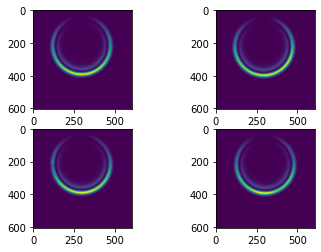

In [17]:
import matplotlib.pyplot as plt
h5f = h5py.File(f"{output_directory}/Dataset_K={K}_Noisy_Non_Noisy_same_angle.h5",'r')
print(len(h5f))
imgs = h5f['12920']
fig=plt.figure()
ax=fig.add_subplot(221)
ax.imshow(imgs[0])
ax=fig.add_subplot(222)
ax.imshow(imgs[1])
ax=fig.add_subplot(223)
ax.imshow(imgs[2])
ax=fig.add_subplot(224)
ax.imshow(imgs[3])
plt.show()

# Tests

In [ ]:
raise ValueError

In [4]:
h5f.close()

In [ ]:
t=time()
h5f = h5py.File(f"{image_directory}/Dataset.h5",'r')
D_mat = h5f[ID][:]
phis = h5f['phis'][:]
#print(list(h5f.keys()))
h5f.close()
print(f"hf5:{time()-t}s size {os.path.getsize(image_directory+'/Dataset.h5')}")   
print(D_mat.dtype, D_mat.shape)

In [ ]:
os.path.getsize(image_directory+'/Dataset.h5')/total

In [ ]:
raise ValueError

In [3]:
import pickle, gzip, lzma, bz2
import h5py


# Initialize the vigilant
try:
    phase_vigilant = json.load(open(f"{output_directory}/STRUCTURE_Grid.json"))
except:
    phase_vigilant = {'R0s':[], 'w0s':[], 'Zs':[], 'IDs':[], 'rel_path':[]}

# Set the objects ready ##################
# The simulator object
simulator=RingSimulator_Optimizer_GPU( n=1.5, a0=1.0, max_k=max_k, num_k=num_k, nx=resolution_side_nx, sim_chunk_x=sim_chunk_ax, sim_chunk_y=sim_chunk_ax)

# Execute the stuff #####################
i=1
total=Z_s.shape[0]*R0_s.shape[0]*w0_s.shape[0]
elapsed=0
beg=time()
output_info_every=100
dump_every=10000

for Z in Z_s:
    for R0 in R0_s:
        for w0 in w0_s:
            ID=f"R0_{R0}_w0_{w0}_Z_{Z}"
            if ID not in phase_vigilant['IDs']:
                # simulate matrix
                #D_matrix = simulator.compute_D_matrix( R0_pixels=R0, Z=Z, w0_pixels=w0)
                D_matrix = simulator.compute_pieces_for_I_LP(R0_pixels=R0, Z=Z, w0_pixels=w0)
                
                # save the matrix
                rel_path=f"{image_directory}/{ID}.pkl.lzma"
                #np.save( rel_path, D_matrix, allow_pickle=False)
                print(f"\nDUMP {i}")
                t=time()
                pickle.dump(D_matrix, lzma.open(rel_path, 'wb'))
                print(f"lzma:{time()-t}s size {os.path.getsize(rel_path)}")
                t=time()
                pickle.dump(D_matrix, gzip.open(rel_path+".gzip", 'wb'))
                print(f"gzip:{time()-t}s size {os.path.getsize(rel_path+'.gzip')}")
                t=time()
                pickle.dump(D_matrix, bz2.open(rel_path+".bz2", 'wb'))
                print(f"bz2:{time()-t}s size {os.path.getsize(rel_path+'.bz2')}")
                t=time()
                fp = np.memmap(rel_path+".p", dtype='complex64', mode='w+', shape=(3,image_shortest_side,image_shortest_side))
                fp=D_matrix
                print(f"memmap:{time()-t}s size {os.path.getsize(rel_path+'.p')}")
                t=time()
                h5f = h5py.File(rel_path+'.h5', 'w')
                h5f.create_dataset('dataset_1', data=D_matrix, compression="gzip", shuffle=True) #, compression_opts=9)
                h5f.close()
                print(f"hf5 lzf:{time()-t}s size {os.path.getsize(rel_path+'.h5')}")     


                
                print(f"\nLOAD {i}")
                t=time()
                D_mat=pickle.load(lzma.open(rel_path, 'rb'))
                print(f"lzma:{time()-t}s size {os.path.getsize(rel_path)}")
                t=time()
                D_mat=pickle.load(gzip.open(rel_path+".gzip", 'rb'))
                print(f"gzip:{time()-t}s size {os.path.getsize(rel_path+'.gzip')}")
                t=time()
                D_mat=pickle.load( bz2.open(rel_path+".bz2",'rb'))
                #print(D_mat.dtype, D_mat.shape)
                print(f"bz2:{time()-t}s size {os.path.getsize(rel_path+'.bz2')}")     
                t=time()
                D_mat= np.memmap(rel_path+".p", dtype='complex64', mode='r+', shape=(3,image_shortest_side,image_shortest_side))
                print(f"memmap:{time()-t}s size {os.path.getsize(rel_path+'.p')}")     
                t=time()
                h5f = h5py.File(rel_path+'.h5','r')
                D_mat = h5f['dataset_1'][:]
                h5f.close()
                print(f"hf5:{time()-t}s size {os.path.getsize(rel_path+'.h5')}")     
                print(type(D_mat), D_mat.dtype, D_mat.shape)
                print(np.allclose(D_mat, D_matrix))

                

                if D_matrix is None:
                    raise ValueError

                #append the data
                phase_vigilant['IDs'].append(ID)
                phase_vigilant['R0s'].append(float(R0))
                phase_vigilant['Zs'].append(float(Z))
                phase_vigilant['w0s'].append(float(w0))
                phase_vigilant['rel_path'].append(rel_path)
                
                
                if i%output_info_every==0:
                    display.clear_output(wait=True)
                    elapsed=time()-beg
                    print(f"["+'#'*(int(100*i/total))+' '*(100-int(100*i/total))+f"] {100*i/total:3.4}% \n\nSimulated: {i}/{total}\nElapsed time: {elapsed//3600} h {elapsed//60-(elapsed//3600)*60} min {elapsed-(elapsed//60)*60-(elapsed//3600)*60:2.4} s")
                    if i%dump_every==0:
                        # we save the progess (in order to be able to quit and resume)
                        json.dump(phase_vigilant, open( f"{output_directory}/STRUCTURE_Grid.json", "w"))
            i+=1
print("\n\nFINISHED!!!")

NameError: name 'image_directory' is not defined

In [ ]:
%%time
for i in range(1000):
    a=np.abs(D_mat)**2

In [ ]:
%%time
for i in range(1000):
    a=(D_mat*D_mat.conjugate()).real

In [ ]:
%%time
for i in range(1000):
    a=D_mat.real**2+D_mat.imag**2

In [ ]:
%%time
for i in range(1000):
    a=D_mat.real**2
    a+=D_mat.imag**2

In [ ]:
np.allclose( (D_mat*D_mat.conjugate()).real, D_mat.real**2+D_mat.imag**2, rtol=0)